# Business Analytics for a Retail Store using Python

## Part 2: Story Telling using the Data

In addition to eventually coming up with a model that explains demand, management would also like to know the relationships and patterns found within our data. Specifically:
 1. Which month has the highest average sales in dollars for store 312?
 2. Which specific week had the highest sales in dollars for store 312?
 - Which SKU is the most popular in store 312? Is it the one with the most profit?
 - Are the sales (in units) between the different SKUs from MA Excellent Products correlated for store 312?
 - TinyCo is thinking of running a one day promo on eachweek – which day of week makes the most sense for store 312?
 - How do these SKUs behave differently in the other stores?

Let us answer all these questions, one at a time.

### 1. Which month has the highest average sales in dollars for Store 312?

Let's import the necessary modules and our data.

In [571]:
import pandas as pd
import numpy as np
import datetime as dt
import time

In [575]:
Store_312 = pd.read_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Store_312_clean.csv", index_col=0)

In [576]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales
0,79444,50012011250,312,2014-08-04,3.0,29.97
1,79445,50012011250,312,2014-08-05,2.0,19.98
2,79446,50012011250,312,2014-08-06,5.0,49.95
3,79447,50012011250,312,2014-08-07,3.0,29.97
4,79448,50012011250,312,2014-08-08,7.0,69.93


In [577]:
Store_312.dtypes

DB_ID             int64
SKU               int64
Store             int64
Date             object
Unit Sales      float64
Dollar Sales    float64
dtype: object

To answer our question, we need to strip the month from our datetime column.

In [578]:
def strip_month(x):
    return x.month

def strip_Y_month(x):
    return x.strftime("%Y-%m")

In [579]:
Store_312["Date"] = pd.to_datetime(Store_312["Date"])

In [580]:
Store_312.dtypes

DB_ID                    int64
SKU                      int64
Store                    int64
Date            datetime64[ns]
Unit Sales             float64
Dollar Sales           float64
dtype: object

In [581]:
Store_312["Month"] = Store_312["Date"].apply(strip_month)
Store_312["Year/Month"] = Store_312["Date"].apply(strip_Y_month)

In [582]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08


We now have columns that show both month, and a combined year/month. The latter could come in handy. Now to answer the question.

In [583]:
Store_312.pivot_table(values="Dollar Sales", index="Month", aggfunc="mean").sort_values("Dollar Sales", ascending=False).head(1)

,Dollar Sales
Month,
5,103.187063


The pivot table above shows that, on average, month 5 (May) has the highest sales in a year.

### 2. Which specific week had the highest sales in dollars for store 312?

In [584]:
def strip_week(x):
    return x.strftime("%Y-%W")

In [586]:
Store_312["Week"] = Store_312["Date"].apply(strip_week)

In [587]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31


We stripped a week from the date column and created a new column with the format 'Year-Week Number'.

Now for the analysis.

In [638]:
Store_312.pivot_table(values="Dollar Sales", index=["Week", "Month"], aggfunc="sum").sort_values("Dollar Sales", ascending=False).head(1)

,,Dollar Sales
Week,Month,
2016-21,5,6546.99


Our analysis shows us that week 21 in the year 2016 (which is in May) had the highest sales.

A good analysis to also do would be to see which week on average is the highest selling in a month.

In [589]:
import calendar

def strip_week_of_month(tgtdate):
    
    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = dt.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

In [590]:
Store_312["Week of month"] = Store_312["Date"].apply(strip_week_of_month)

In [591]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1


The function we just used to generate monthly week numbers has a few surprises. It has weeks numbered 0 and some numbered 5. Upon closer inspection and reference to a calendar, we can see that the function only recognises a week as week 1 if it starts on a Monday. The trailing days prior to it are desgnated week 0. Week 5 is easier to explain as some months can actually stretch into a 5th week.

But how does this affect our analysis? To make it easier, we can split our months into three bins:
 - Beginning (weeks 0 and 1),
 - Middle (weeks 2 and 3),
 - End (weeks 4 and 5).
 
Our analysis can then be based on which period experiences the best and/or lowest sales.

In [592]:
def bin_weeks(x):
    if x == 0 or x == 1:
        x = "Beginning"
    elif x == 2 or x == 3:
        x = "Middle"
    else:
        x = "End"
    return x

In [593]:
Store_312["Period of month"] = Store_312["Week of month"].apply(bin_weeks)

In [594]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1,Beginning
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1,Beginning
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1,Beginning
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1,Beginning
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1,Beginning


Now to aggregate over the periods.

In [639]:
Store_312.pivot_table(values="Dollar Sales", index="Period of month", aggfunc="mean").sort_values("Dollar Sales", ascending=False)

,Dollar Sales
Period of month,
Middle,79.927711
Beginning,78.028893
End,70.512873


The analysis shows us that the period with highest dollar sales is the middle of the month, on average.

### 3. Which SKU is the most popular in store 312? Is it the one with the most profit?

In [596]:
SKU_Master = pd.read_excel("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/TinyCo_Data_RAW.xlsx", sheet_name="SKU Master")

In [597]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales
4,5001,201,12,4,50012011240,2.5,7.99,China Imports
5,5001,201,12,5,50012011250,7.5,9.99,China Imports
6,5001,201,13,4,50012011341,8.0,6.99,China Imports
7,5001,300,1,1,50013000110,6.5,12.99,China Imports


In [598]:
Store_312["Unit Cost"] = [7.5 if x == 8000520021 else 9.0 if x == 8000451112
                          else 25.0 if x == 7312455520 else 14.5 if x == 7312455530
                          else 2.5 if x == 50012011240 else 7.5 if x == 50012011250
                          else 8.0 if x == 50012011341 else 6.5 if x == 50013000110
                          else 0 for x in Store_312["SKU"]]

In [599]:
Store_312[["SKU", "Unit Cost"]].groupby("SKU").agg("mean")

# We are grouping by "SKU" then aggregating the "Unit Cost" by mean.
# Since we expect the "Unit Cost" to be the same throughtout a group,
# it should return the same value.

,Unit Cost
SKU,
7312455520,25.0
7312455530,14.5
8000451112,9.0
8000520021,7.5
50012011240,2.5
50012011250,7.5
50012011340,0.0
50012011341,8.0
50013000110,6.5


Seems our conditional list comprehension achieved what we wanted. However, remember that rogue SKU (50012011340) from Part 1? We gave it a zero because we do not know what its cost is since it's not in the SKU_Master table.

We can try and predict it using a few methods. If we check the SKU_Master table, *costing* and *pricing* seem to follow a pattern - this suggests a correlation. We can model a regression line but this seems like too much work. Let us retrieve a row from the Store_312 dataframe first and see if we can find useful information there.

In [600]:
Store_312[Store_312["SKU"]==50012011340].head(1)

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost
616,82516,50012011340,312,2014-08-04,3.0,14.97,8,2014-08,2014-31,1,Beginning,0.0


"Dollar Sales" is simply a product of "Unit Sales" and "Pricing". So we should be able to find the price of this SKU via division.

In [601]:
Rogue_SKU_price = 14.97/3.0
Rogue_SKU_price

4.99

Let's see if the profit margin is calculated the same way for each SKU.

In [602]:
SKU_Master["Profit Margin (%)"] = ((SKU_Master["Price"] - SKU_Master["Cost"]) / SKU_Master["Cost"]) * 100

In [603]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor,Profit Margin (%)
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products,33.200000
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products,44.333333
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products,27.960000
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales,58.551724
4,5001,201,12,4,50012011240,2.5,7.99,China Imports,219.600000
5,5001,201,12,5,50012011250,7.5,9.99,China Imports,33.200000
6,5001,201,13,4,50012011341,8.0,6.99,China Imports,-12.625000
7,5001,300,1,1,50013000110,6.5,12.99,China Imports,99.846154


The proft margin is not consistent across all SKUs, so we will need to find another way to predict that for our rogue SKU. There also seems to be an error in row 6. The price is lesser than the cost. Let's find a solution to that.

In [604]:
Store_312[Store_312["SKU"]==50012011341].head(1)

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost
963,82863,50012011341,312,2016-01-04,2.0,9.98,1,2016-01,2016-01,1,Beginning,8.0


In [605]:
9.98/2

4.99

The unit price in the Store_312 table is actually not the same as the one in the SKU_Master table. This is one of the cases that we need to flag a problem and consult management before proceeding. (*Since this is a hypothetical project, let's just say we did this and got a response*).

After consulting management, we are told that the error is both on the cost and price in the SKU_Master table. The 4.99 price calculated from the Store_312 table is the actual price. The cost is 2.50. Our rogue SKU's (50012011340) cost is also 2.50.

Now to edit both the tables with this new information

In [606]:
SKU_Master.at[6, "Cost"] =  2.5
SKU_Master.at[6, "Price"] = 4.99

In [607]:
SKU_Master["Profit Margin (%)"] = ((SKU_Master["Price"] - SKU_Master["Cost"]) / SKU_Master["Cost"]) * 100

In [608]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor,Profit Margin (%)
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products,33.200000
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products,44.333333
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products,27.960000
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales,58.551724
4,5001,201,12,4,50012011240,2.5,7.99,China Imports,219.600000
5,5001,201,12,5,50012011250,7.5,9.99,China Imports,33.200000
6,5001,201,13,4,50012011341,2.5,4.99,China Imports,99.600000
7,5001,300,1,1,50013000110,6.5,12.99,China Imports,99.846154


Let's add the rogue SKU to the SKU_Master table.

In [610]:
row8 = [[5001, 201, 13, 4, 50012011340, 2.5, 4.99, "China Imports", 99.600000]]
cols = SKU_Master.columns
cols = list(cols)
df1 = pd.DataFrame(row8, columns=cols)
df1
SKU_Master = SKU_Master.append(df1, ignore_index=True)

In [611]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor,Profit Margin (%)
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products,33.200000
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products,44.333333
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products,27.960000
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales,58.551724
4,5001,201,12,4,50012011240,2.5,7.99,China Imports,219.600000
5,5001,201,12,5,50012011250,7.5,9.99,China Imports,33.200000
6,5001,201,13,4,50012011341,2.5,4.99,China Imports,99.600000
7,5001,300,1,1,50013000110,6.5,12.99,China Imports,99.846154
8,5001,201,13,4,50012011340,2.5,4.99,China Imports,99.600000


Now let's change those 0s in Store_312 that are against SKU 50012011340.

In [612]:
Store_312["Unit Cost"][Store_312["SKU"]==50012011340] = 2.5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [613]:
Store_312["Unit Cost"][Store_312["SKU"]==50012011341] = 2.5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Our Store_312 dataframe has been updated. Now to carry on to the purpose of our analysis. Let's add a profit column.

In [614]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1,Beginning,7.5
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1,Beginning,7.5
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1,Beginning,7.5


In [640]:
Store_312["Profit"] = Store_312["Dollar Sales"] - (Store_312["Unit Sales"] * Store_312["Unit Cost"])

In [641]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1,Beginning,7.5,4.98
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1,Beginning,7.5,12.45
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1,Beginning,7.5,17.43


Now let's aggreagate our data to find out which SKU is the most popular, i.e., the one with the most unit sales.

In [642]:
Store_312.pivot_table(values=["Unit Sales", "Profit"], index="SKU", aggfunc="sum").sort_values("Unit Sales", ascending=False)

,Profit,Unit Sales
SKU,,
8000451112,49736.02,11398.0
8000520021,6827.58,2742.0
50012011250,6807.39,2011.0
7312455530,9687.09,1141.0
50012011240,7132.23,1127.0
50013000110,5198.49,801.0
7312455520,5081.73,727.0
50012011340,1579.88,612.0
50012011341,747.16,284.0


The most popular SKU in Store_312 is 8000451112, and yes, it is the one with the greatest profit.

As we are about to move on to our next problem, the accounting team tells us there is an issue with the Store_312 table. The SKU 7312455520 seems to be recording negative profits on their end. Let's check if this is true.

In [623]:
Store_312[(Store_312["SKU"]==7312455520) & (Store_312["Profit"]<0)].head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit
2123,94598,7312455520,312,2014-08-20,1.0,22.99,8,2014-08,2014-33,3,Middle,25.0,-2.01
2129,94604,7312455520,312,2014-09-03,1.0,22.99,9,2014-09,2014-35,1,Beginning,25.0,-2.01
2130,94605,7312455520,312,2014-09-03,1.0,22.99,9,2014-09,2014-35,1,Beginning,25.0,-2.01
2134,94609,7312455520,312,2014-09-10,1.0,22.99,9,2014-09,2014-36,2,Middle,25.0,-2.01
2141,94616,7312455520,312,2014-09-17,1.0,22.99,9,2014-09,2014-37,3,Middle,25.0,-2.01


The accounting team is right. There are multiple instances where 7312455520 is recording negative profits.

The problem seems to be the unit price being used to calculate "Dollar Sales" for this particular SKU. 7312455520 is using the unit price for 7312455530, 22.99, instead of 31.99. Let us correct this.

In [632]:
Store_312.loc[Store_312["SKU"]==7312455520, "Dollar Sales"] = Store_312.loc[Store_312["SKU"]==7312455520, "Unit Sales"] * 31.99

In [633]:
Store_312[(Store_312["SKU"]==7312455520)].head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit
2122,94597,7312455520,312,2014-08-20,1.0,31.99,8,2014-08,2014-33,3,Middle,25.0,0.99
2123,94598,7312455520,312,2014-08-20,1.0,31.99,8,2014-08,2014-33,3,Middle,25.0,-2.01
2124,94599,7312455520,312,2014-08-22,2.0,63.98,8,2014-08,2014-33,3,Middle,25.0,1.98
2125,94600,7312455520,312,2014-08-28,1.0,31.99,8,2014-08,2014-34,4,End,25.0,0.99
2126,94601,7312455520,312,2014-08-29,2.0,63.98,8,2014-08,2014-34,4,End,25.0,1.98


Let's run our "Profit" column code again to update the column.

In [635]:
Store_312["Profit"] = Store_312["Dollar Sales"] - (Store_312["Unit Sales"] * Store_312["Unit Cost"])

Let's check if the negative profits are still there.

In [637]:
Store_312[(Store_312["SKU"]==7312455520) & (Store_312["Profit"]<0)].head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit


We returned an empty dataframe, meaning that our problem has been resolved. This will obviously change our prior results, so let's run that code again **inplace for convenience sake.**

### 4. Are the sales (in units) between the different SKUs from MA Excellent Products correlated for store 312?

It is important to know if there exists a correlation between our different products to better understand customer buying habits. One product might influence the purchase of another. Likewise, we might be stocking too similar products such that one product is being overwhelmingly preffered to another.

Here we are particularly interested in products from the vendor "MA Excellent Products". Let's check the SKU_Master table to see which SKUs are these.

In [643]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor,Profit Margin (%)
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products,33.200000
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products,44.333333
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products,27.960000
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales,58.551724
4,5001,201,12,4,50012011240,2.5,7.99,China Imports,219.600000
5,5001,201,12,5,50012011250,7.5,9.99,China Imports,33.200000
6,5001,201,13,4,50012011341,2.5,4.99,China Imports,99.600000
7,5001,300,1,1,50013000110,6.5,12.99,China Imports,99.846154
8,5001,201,13,4,50012011340,2.5,4.99,China Imports,99.600000


The SKUs from this particular vendor are '8000520021', '8000451112' and '7312455520'.

In [644]:
SKU_Subset = Store_312[(Store_312["SKU"] == 8000520021) | (Store_312["SKU"] == 8000451112) | (Store_312["SKU"] == 7312455520)]

In [669]:
SKU_pivot = SKU_Subset.pivot_table(index="Date", values = 'Unit Sales', columns = 'SKU', aggfunc="sum",fill_value=0)

In [670]:
SKU_pivot.head()

SKU,7312455520,8000451112,8000520021
Date,,,
2014-08-20,2,0,1
2014-08-21,0,0,3
2014-08-22,2,0,6
2014-08-23,0,0,10
2014-08-25,0,8,1


Using "Date" as our index is our best option since it saves us most of our data. Products can be bought on the same day hence a row in the pivot table can contain more than one SKU. If an SKU wasn't bought on a particular date, we set it to 0.

Now we have dataframe with with columns of equal dimensions and which doesn't have NaN values. We can now calculate correlation coefficients to see if any significant linear relations exist.

In [671]:
SKU_pivot.corr()

SKU,7312455520,8000451112,8000520021
SKU,,,
7312455520,1.000000,-0.105409,-0.144438
8000451112,-0.105409,1.000000,0.246693
8000520021,-0.144438,0.246693,1.000000


There doesn't seem to be any major correlation between the SKUs, but let's visualize these results.

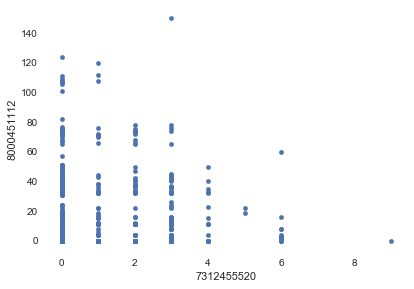

In [672]:
SKU_pivot.plot(7312455520, 8000451112, kind="scatter", figsize=(6.5,4.5)).set_facecolor('w')
plt.grid()

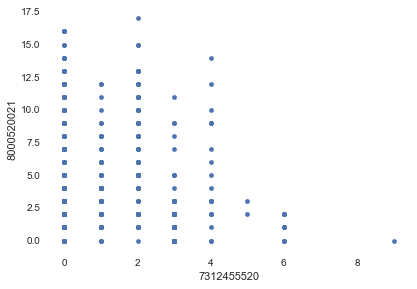

In [675]:
SKU_pivot.plot(7312455520, 8000520021, kind="scatter", figsize=(6.5,4.5)).set_facecolor('w')
plt.grid()

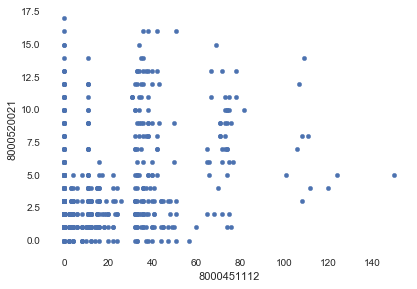

In [677]:
SKU_pivot.plot(8000451112, 8000520021, kind="scatter", figsize=(6.5,4.5)).set_facecolor('w')
plt.grid()

Our scatter plots display very interesting relationships between our SKUs. While the relationships aren't exactly linear, the scatter plots show that as sales in SKU 7312455520 increase, those for 8000451112 and 8000520021 decrease.

### 5. TinyCo is thinking of running a one day promo on each week – which day of week makes the most sense for store 312?

In [678]:
Store_312.head()

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1,Beginning,7.5,4.98
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1,Beginning,7.5,12.45
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1,Beginning,7.5,17.43


To answer this question, first we need to strip day of the week from our "Date" column.

In [679]:
Store_312["Day of the week"] = Store_312["Date"].apply(lambda x: x.strftime("%w"))

In [681]:
Store_312.head(10)

,DB_ID,SKU,Store,Date,Unit Sales,Dollar Sales,Month,Year/Month,Week,Week of month,Period of month,Unit Cost,Profit,Day of the week
0,79444,50012011250,312,2014-08-04,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47,1
1,79445,50012011250,312,2014-08-05,2.0,19.98,8,2014-08,2014-31,1,Beginning,7.5,4.98,2
2,79446,50012011250,312,2014-08-06,5.0,49.95,8,2014-08,2014-31,1,Beginning,7.5,12.45,3
3,79447,50012011250,312,2014-08-07,3.0,29.97,8,2014-08,2014-31,1,Beginning,7.5,7.47,4
4,79448,50012011250,312,2014-08-08,7.0,69.93,8,2014-08,2014-31,1,Beginning,7.5,17.43,5
5,79449,50012011250,312,2014-08-09,4.0,39.96,8,2014-08,2014-31,1,Beginning,7.5,9.96,6
6,79450,50012011250,312,2014-08-11,4.0,39.96,8,2014-08,2014-32,2,Middle,7.5,9.96,1
7,79451,50012011250,312,2014-08-12,4.0,39.96,8,2014-08,2014-32,2,Middle,7.5,9.96,2
8,79452,50012011250,312,2014-08-13,1.0,9.99,8,2014-08,2014-32,2,Middle,7.5,2.49,3
9,79453,50012011250,312,2014-08-14,3.0,29.97,8,2014-08,2014-32,2,Middle,7.5,7.47,4


Now we should aggregate over the "Day of the week" column to see which day, on average, has the least sales. That's the day we should run a promotion on to boost sales.

In [683]:
Store_312.pivot_table(values="Dollar Sales", index="Day of the week", aggfunc="mean").sort_values("Dollar Sales", ascending=True).head(1)

,Dollar Sales
Day of the week,
3,51.980283


**Wednesday** is the day that Store 312 should run a promotion on since it's the day with the least sales.

### 6. How do these SKUs behave differently in the other stores?

This is where this part of the project ends. You're free to critic my work so far and make conttributions of your.

Please go through the other stores, go through similar data cleaning & analysis processes and go on to answer the question above.

If you'd like to see the overall demand model for Store 312, move on to the next notebook.

In [688]:
Store_312.to_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Store_312_ts.csv")

In [689]:
SKU_Master.to_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/SKU_Master_clean.csv")

<br>
<br>
<br>
<br>
***
<footer>_Author: Simbarashe Chikaura -- Data Scientist_</footer>
***